<a href="https://colab.research.google.com/github/COTILab/MCX24Workshop/blob/master/Training/MCX2024_2D_multi_spectral_redbird.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Workshop Logo](https://mcx.space/wiki/upload/mcx24_logo.png)
# MCX Training Workshop 2024 - Day 2, Session 2D

## Session 2D: Redbird-m Training Part-2 (multi-spectral DOT reconstruction)


> **Training Goals**: <font color='green'>In this session you will learn how to: 1) setup the simulation environment in Redbird-m to perform FD/CW multi-spectral reconstructions, 2) Setup the simulation environment in Redbird-m to perform bybrid FD + CW multi-spectral reconstructions, 3) run and visualize frequency domain (FD) or continuous wave (CW) forward simulations in Redbird-m using point-source/detector arrays and wide-field source/detector patterns, and 4) Visualize the simulated data (amplitude and/or phase) and the sensitivity matrix</fonts>


# <font color='orange'>Step 0: Setting up MCX and Octave environments within Google Colab</font>

> **You must rerun all cells in Step 0 in appearance order when you start a new session, or after reconnect to a runtime**

To run interactive Octave sessions inside a Google Colab Jupyter Notebook environment, we need to install the following dependencies
- GNU Octave via `sudo apt-get install octave`
- Oct2py Python module via `pip install oct2py`, and
- enable Oct2py in Jupyter Notebook via "magic command" `%load_ext oct2py.ipython`

This unit does not require GPU.

In [ ]:
#@title <font color='orange'>Init 1: Initial setup of environment for running MCXLAB (run the below section once)</font>

# install octave and oct2py
! sudo apt-get update && sudo apt-get install octave jq libpocl2 pocl-opencl-icd    # install octave (a free matlab clone)
! pip install oct2py jdata bjdata matplotlib   # install oct2py, jdata, bjdata and matplotlib Python modules

# add octave support to colab notebook
%load_ext oct2py.ipython

# download and unzip mcxlab
! rm -rf MCXStudio*
! curl https://mcx.space/nightly/release/MCX24/MCXStudio-linux-x86_64-nightlybuild.zip -O MCXStudio-linux-x86_64-nightlybuild.zip # download MCX suite
! unzip -o MCXStudio-linux-x86_64-nightlybuild.zip && rm -rf MCXStudio-linux-x86_64-nightlybuild.zip # unzip MCX suite

# add executable to the shell's paths
! cp -a "$PWD/MCXStudio/MCXSuite/mcx/bin/mcx" "/usr/local/bin"
! cp -a "$PWD/MCXStudio/MCXSuite/mcxcl/bin/mcxcl" "/usr/local/bin"
! cp -a "$PWD/MCXStudio/MCXSuite/mmc/bin/mmc" "/usr/local/bin"
! cp -a "$PWD/MCXStudio/MATLAB/zmat/octave/gnu-linux-x86_64/zipmat.mex" "$PWD/MCXStudio/MATLAB/zmat/"

# if a GPU runtime can not be allocated, run this section to setup OpenCL and MCXLAB-CL
! [[ ! -f `which nvidia-smi` ]] && mv "/usr/local/bin/mcxcl" "/usr/local/bin/mcx"
#! mcx -L

### <font color='orange'>Init 2: Only need to run this once at the beginning</font>

In [ ]:
%%octave

addpath([pwd filesep 'MCXStudio/MATLAB/mcxlab']);                     % add path to mcxlab
addpath([pwd filesep 'MCXStudio/MCXSuite/mcx' filesep 'utils']);      % add path to mcx helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/mmclab']);                     % add path to mmclab
addpath([pwd filesep 'MCXStudio/MCXSuite/mmc' filesep 'matlab']);     % add path to mmc helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/iso2mesh']);                   % add path to iso2mesh/jsonlab
addpath([pwd filesep 'MCXStudio/MATLAB/brain2mesh']);                 % add path to brain2mesh
addpath([pwd filesep 'MCXStudio/MATLAB/zmat']);                       % add path to zmat for data compression
addpath([pwd filesep 'MCXStudio/MATLAB/redbird-m/matlab']);           % add path to redbird-m

struct_levels_to_print(0);
print_struct_array_contents(0);

if(system('which nvidia-smi'))                   % if this runtime does not have NVIDIA GPU support
    addpath([pwd filesep 'MCXStudio/MATLAB/mcxlabcl']);    % add path to mcxlabcl
    USE_MCXCL=1;                                 % set USE_MCXCL flag in the base workspace
end

### <font color='orange'>Init 3: Verify your environments</font>

---

In [ ]:
%%octave

which mcx
which s2m
which zipmat

%mcxlab('gpuinfo')     % use this command to list supported CPU or GPU in octave
%unix('mcx -L')        % use -L flag to list GPU in the command line

## Multi-spectra Redbird-m reconstruction

In this section we demonstrate the extended capabilities of Redbird-m to perform multi-spectral reconstructions of given chromophores. Redbird-m support native reconstructions of oxy- (HbO) and deoxy- (Hb) hemoglobin, H$_2$O and lipid absorption chromophores while assuming Mie scattering ($\mu_s' = A(\lambda/500)^{-b}$). However, any absorption spectra can be loaded to produce spectral reconstructions and Rayleight scattering can also be supported.

In specific, in the followign examples we perform reconstruction of oxy-hemoglobin (HbO) and deoxy-hemoglobin (Hb) as well as Mie Scattering coefficients A & b.

In this section, we prepare a 100x100x40 mm$^3$ heterogenous mesh domain of with two inclusions of 2x absorption contrast located off-center in the z-axis (z = 15 mm).

### CW/FD point-source array forward solutions

First, we define the general setting to create the heterogenous domain along with a 3x3 point-source/detector array in a transmission geometry. The optical properties of each domain segment is given as the combination of chromophores concentrations for $\mu_a$ and scattering coefficients for $\mu_s'$.

We run a forward simulation on the heterogeneous domain (cfg0) to create simulated data (detphi0). Then, we create a homogeneous forward mesh (cfg) over which the inverse problem solution will be projected. We also create a sparse reconstruction mesh (recon) to speed up the Jacobian inversion and project those solutions over the forward mesh.

#### Define general settings for Redbird-m simulation

Surface Mesh Extraction Utility (Based on CGAL 3.8)

(modified for iso2mesh by Qianqian Fang)

http://iso2mesh.sf.net

RNG seed 1648335518

set initial mesh size to 50

Refining... maximum node number is set to 40000

done.

Final number of points: 289

WARNING- Some triangles have been reversed to achieve orientation.

Surface Mesh Extraction Utility (Based on CGAL 3.8)

(modified for iso2mesh by Qianqian Fang)

http://iso2mesh.sf.net

RNG seed 1648335518

set initial mesh size to 50

Refining... maximum node number is set to 40000

done.

Final number of points: 289

WARNING- Some triangles have been reversed to achieve orientation.

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

ans = -26.152

mfreq = 67

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

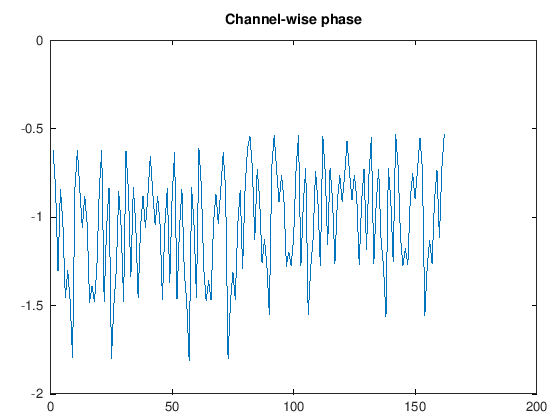

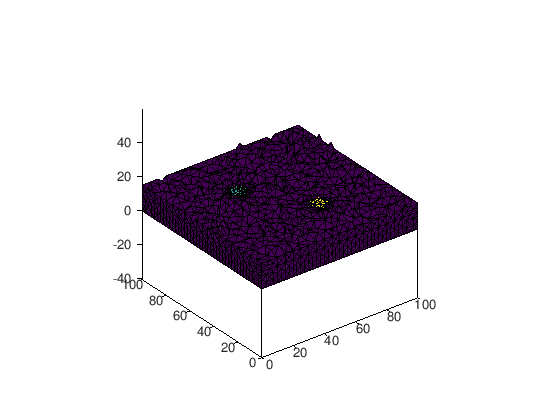

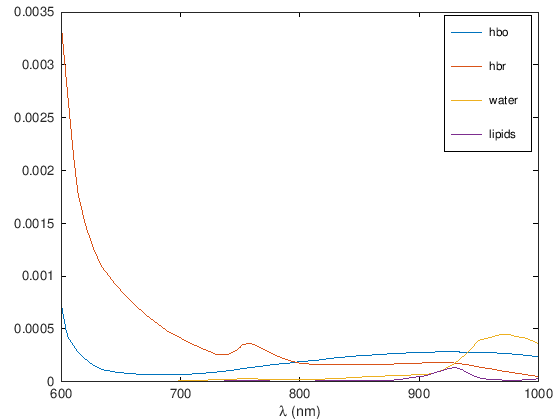

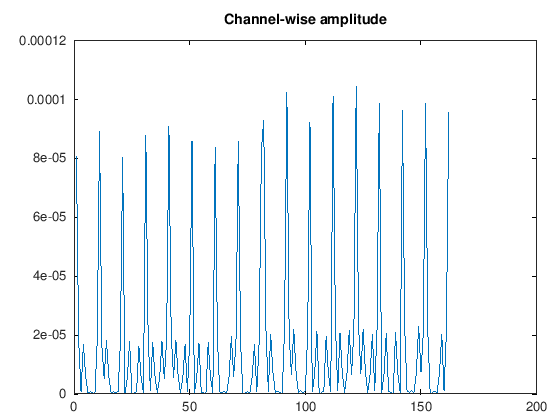

In [ ]:
%%octave

clear cfg0 cfg recon

domsz = [100 100 40];     % Domain size
s0    = [35, 65, 15 5;... % Central position xyz and radius of the inclusion (in mm)
         60, 30, 15 5];

% Bounding box w/ 2 inclusions
resmesh = 5;
[nobbx,elembbx] = meshgrid5(0:resmesh:domsz(1),0:resmesh:domsz(2),0:resmesh:domsz(3)); % Meshbox domain (in mm)
fcbbx   = volface(elembbx);
[nobbx,fcbbx] = removeisolatednode(nobbx,fcbbx);
[nosp1,fcsp1] = meshasphere(s0(1,1:3),s0(1,4),1); % Sphare mesh location (s0, radious, maxvol)
[nosp2,fcsp2] = meshasphere(s0(2,1:3),s0(2,4),1); % Sphare mesh location (s1, radious, maxvol)
[no,fc]       = mergemesh(nobbx,fcbbx,nosp1,fcsp1,nosp2,fcsp2); % Merge meshbox and sphere meshes (FOR DUAL INCLUSION DOMAIN)
[cfg0.node, cfg0.elem] = s2m(no,fc(:,1:3),1,25,'tetgen1.5',[11 1 1;s0(1,1:3);s0(2,1:3)]); % Generate measured/real heterogeneous domain
clear nobbx elembbx fcbbx nosp1 fcsp1 nosp2 fcsp2 no fc

% Visualize domain
figure, plotmesh(cfg0.node, cfg0.elem,char(strcat('z<',num2str(s0(1,3)))))

figure,plot(600:1000,rbextinction(600:1000,{'hbo','hbr','water','lipids'}))
legend('hbo','hbr','water','lipids')
xlabel('\lambda (nm)')

% General settings for RB simulations
cfg0.param         = struct;       % Define multi-spectral optical properties [Bulk OPs Inclusion OPs]
cfg0.param.hbo     = [10 20 20];
cfg0.param.hbr     = [ 4  8  8];
cfg0.param.scatamp = [1.6e-6 2.4e-6 2.4e-6];
cfg0.param.scatpow = [0.9177 0.9177 0.9177];

% Declare dummy optical properties field ('cfg0.prop') for letting the code know there will be two wavelengths.
% Assigned values are not relevant but field of cfg0.prop are important to define what wavelengths to get simulated data.
cfg0.prop        = containers.Map();  % if both prop and param are defined, param will overwrite prop
cfg0.prop('690') = [0 0 1 1; 0.006 0.8 0 1.37; 0.012 1.0 0 1.37; 0.012 1.0 0 1.37];
cfg0.prop('830') = [0 0 1 1; 0.006 0.8 0 1.37; 0.012 1.0 0 1.37; 0.012 1.0 0 1.37];

mfreq      = 67 # @param [0, 67] {type:"raw"}
cfg0.omega = mfreq*1e6*2*pi;

% Define parameters for RB src/det point source
nsrc        = [3 3]; % Number of src/det in xy axis
[xi,yi]     = meshgrid(linspace(20,80,nsrc(1)),linspace(20,80,nsrc(2)));
cfg0.srcpos = [xi(:),yi(:),zeros(numel(yi),1)];
cfg0.detpos = [xi(:),yi(:),domsz(3)*ones(numel(yi),1)];
cfg0.srcdir = [0 0  1];
cfg0.detdir = [0 0 -1];

cfg = cfg0;
[cfg0,sd0] = rbmeshprep(cfg0);

% Run RB forward simulation
[detphi0,phi0] = rbrunforward(cfg0,'sd',sd0);

% Set fwd mesh to be homogeneous
cfg = rbsetmesh(cfg,cfg.node,cfg.elem,cfg.prop,ones(size(cfg.node,1),1));

% Prepare recon mesh
resmesh   = 5;
[no,elem] = meshgrid5(0:resmesh:domsz(1),0:resmesh:domsz(2),0:resmesh:domsz(3)); % Meshbox domain (in mm)
fc        = volface(elem);
[no,fc]   = removeisolatednode(no,fc);
[recon.node, recon.elem] = s2m(no,fc(:,1:3),1,50,'tetgen1.5');
recon.elem = recon.elem(:,1:4);
[recon.mapid,recon.mapweight] = tsearchn(recon.node,recon.elem(:,1:4),cfg.node);
clear no elem fc

% Visualize simulated data
wv = keys(detphi0);
for mm = 1:size(detphi0,1)
  simdata(:,mm) = reshape(detphi0(wv{mm}),[],1);
end
figure,plot(abs(simdata(:))),title('Channel-wise amplitude')
if ~isreal(phi0)
  figure,plot(angle(simdata(:))),title('Channel-wise phase')
end


#### Run bulk optical properties fitting

If utilizing FD sources, we can then perform a bulk optical properties fitting to decouple absorption and reduce scatterring coefficients. Otherwise, set them to be the true background optical properties used to generate synthetic data.

The bulk optical properties are then set as initial guess for launching the iterative reconstruction procedure.

In [ ]:
%%octave

% Set initial guess
recon.bulk  = struct('hbo',8,'hbr',2,'scatamp',1.8e-6,'scatpow',0.9); % Required: this gives initial guesses
recon.param = struct('hbo',8,'hbr',2,'scatamp',1.8e-6,'scatpow',0.9); % Required: this defines chromophores
recon.prop  = containers.Map({'690','830'},{[],[]}); % Required: for wavelengths

if strcmp(class(detphi0),'containers.Map') && cfg0.omega > 0 % If simulating FD data, run bulk fitting

  sd = rbsdmap(cfg);
  [newrecon,resid] = rbrun(cfg,recon,detphi0,sd,'mode','bulk','lambda',1e-5,'maxiter',3);

else % If running CW data, assing bulk optical properties

  % Bulk optical properties to be used
  newrecon.param.hbo     = 10.1285;
  newrecon.param.hbr     =  4.0769;
  newrecon.param.scatamp = 1.9208e-06;
  newrecon.param.scatpow =  0.9050;

end

recon.bulk = newrecon.param;
recon.bulk

[rbrun]: run bulk estimation ...

iter [   1]: residual=2.756980e-03, relres=1.000000e+00 lambda=1.000000e-05 (time=57.526543 s)

iter [   2]: residual=1.210116e-04, relres=4.389280e-02 lambda=1.000000e-05 (time=59.024033 s)

iter [   3]: residual=1.789328e-05, relres=6.490173e-03 lambda=1.000000e-05 (time=55.427860 s)

ans =

  scalar structure containing the fields:

    hbo = 9.9990

    hbr = 4.0159

    scatamp = 1.7545e-06

    scatpow = 0.9112

#### Run iterative reconstruction

In [ ]:
%%octave

sd = rbsdmap(cfg);
[reconMS,residMS,cfgMS] = rbrun(cfg,recon,detphi0,sd,'mode','image','lambda',1e-6,'maxiter',2);

iter [   1]: residual=1.617281e-05, relres=1.000000e+00 lambda=1.000000e-06 (time=57.520539 s)

iter [   2]: residual=1.205503e-06, relres=7.453889e-02 lambda=1.000000e-06 (time=57.689512 s)

#### Visualize reconstructed tomographic images

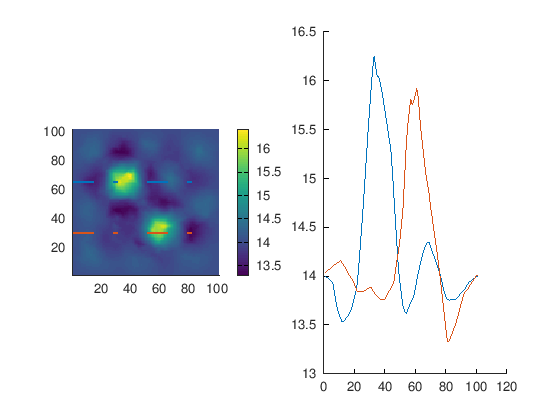

In [ ]:
%%octave

% Generate a cross section slice of the domain
[xi,yi]             = meshgrid(min(cfg.node(:,1),[],1):1:max(cfg.node(:,1),[],1),min(cfg.node(:,2),[],1):1:max(cfg.node(:,2),[],1));
[cutpos,cutvalue,~] = qmeshcut(reconMS.elem,reconMS.node,(reconMS.param.hbo + reconMS.param.hbr),char(strcat('z =',num2str(s0(1,3)))));
clear vphi
vphi(:,:,1)         = griddata(cutpos(:,1),cutpos(:,2),cutvalue,xi,yi);

figure,
subplot(1,2,1);
hold on,imagesc(vphi),colorbar,axis tight, axis equal
for mm = 1:size(s0,1)
    hold on,plot(1:size(vphi,2),s0(mm,2).*ones(1,size(vphi,2)),'LineWidth',4,'LineStyle','-.')
end
subplot(1,2,2)
for mm = 1:size(s0,1)
    hold on,plot(vphi(s0(mm,2),:))
end

### CW/FD wide-field forward solutions

First, we define the general setting to create the heterogenous domain along with a total of 32 wide-field source/detector patterns array (16 in the x-direction and 16 in the y-direction) in a transmission geometry. The optical properties of each domain segment is given as the combination of chromophores concentrations for $\mu_a$ and scattering coefficients for $\mu_s'$.

We run a forward simulation on the heterogeneous domain (cfg0) to create simulated data (detphi0). Then, we create a homogeneous forward mesh (cfg) over which the inverse problem solution will be projected. We also create a sparse reconstruction mesh (recon) to speed up the Jacobian inversion and project those solutions over the forward mesh.

#### Define general settings for Redbird-m simulation

Surface Mesh Extraction Utility (Based on CGAL 3.8)

(modified for iso2mesh by Qianqian Fang)

http://iso2mesh.sf.net

RNG seed 1648335518

set initial mesh size to 50

Refining... maximum node number is set to 40000

done.

Final number of points: 289

WARNING- Some triangles have been reversed to achieve orientation.

Surface Mesh Extraction Utility (Based on CGAL 3.8)

(modified for iso2mesh by Qianqian Fang)

http://iso2mesh.sf.net

RNG seed 1648335518

set initial mesh size to 50

Refining... maximum node number is set to 40000

done.

Final number of points: 289

WARNING- Some triangles have been reversed to achieve orientation.

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

ans = -49.471

mfreq = 67

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

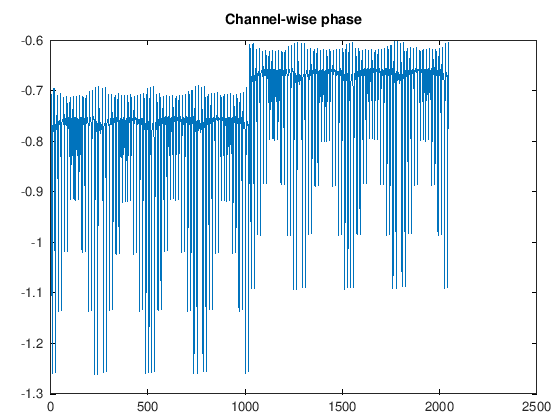

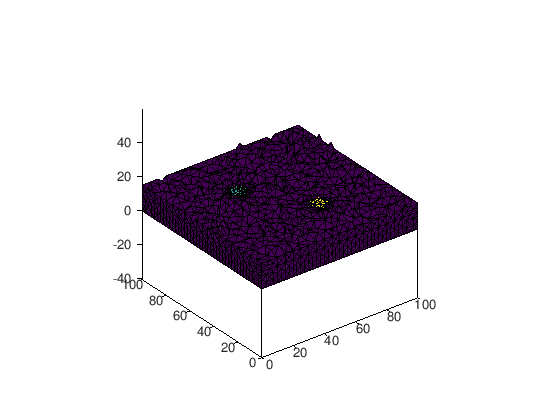

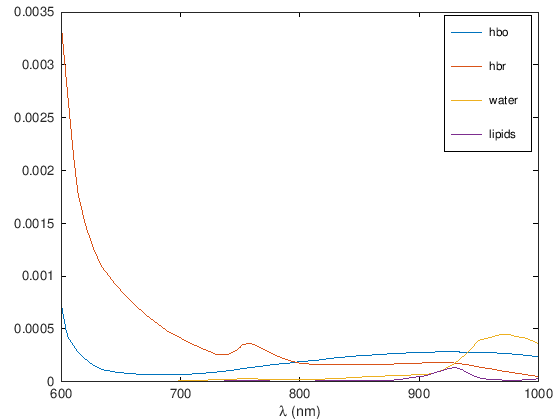

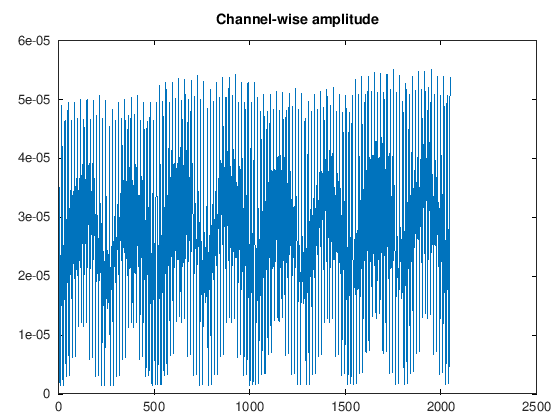

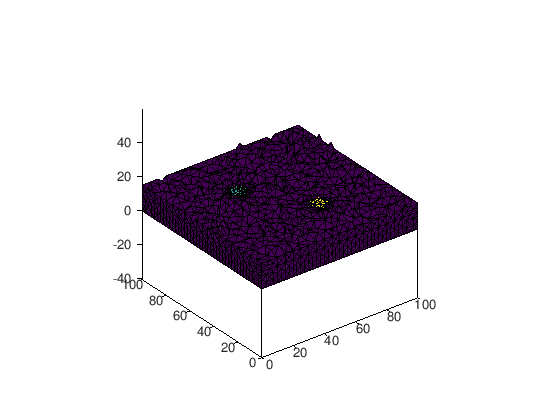

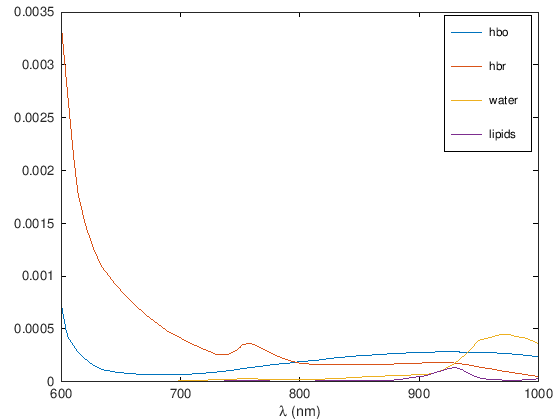

In [ ]:
%%octave

clear cfg0 cfg recon

domsz = [100 100 40];     % Domain size
s0    = [35, 65, 15 5;... % Central position xyz and radius of the inclusion (in mm)
         60, 30, 15 5];

% Bounding box w/ 2 inclusions
resmesh = 5;
[nobbx,elembbx] = meshgrid5(0:resmesh:domsz(1),0:resmesh:domsz(2),0:resmesh:domsz(3)); % Meshbox domain (in mm)
fcbbx   = volface(elembbx);
[nobbx,fcbbx] = removeisolatednode(nobbx,fcbbx);
[nosp1,fcsp1] = meshasphere(s0(1,1:3),s0(1,4),1); % Sphare mesh location (s0, radious, maxvol)
[nosp2,fcsp2] = meshasphere(s0(2,1:3),s0(2,4),1); % Sphare mesh location (s1, radious, maxvol)
[no,fc]       = mergemesh(nobbx,fcbbx,nosp1,fcsp1,nosp2,fcsp2); % Merge meshbox and sphere meshes (FOR DUAL INCLUSION DOMAIN)
[cfg0.node, cfg0.elem] = s2m(no,fc(:,1:3),1,25,'tetgen1.5',[11 1 1;s0(1,1:3);s0(2,1:3)]); % Generate measured/real heterogeneous domain
clear nobbx elembbx fcbbx nosp1 fcsp1 nosp2 fcsp2 no fc

% Visualize domain
figure, plotmesh(cfg0.node, cfg0.elem,char(strcat('z<',num2str(s0(1,3)))))

figure,plot(600:1000,rbextinction(600:1000,{'hbo','hbr','water','lipids'}))
legend('hbo','hbr','water','lipids')
xlabel('\lambda (nm)')

% General settings for RB simulations
cfg0.param         = struct;       % Define multi-spectral optical properties [Bulk OPs Inclusion OPs]
cfg0.param.hbo     = [10 20 20];
cfg0.param.hbr     = [ 4  8  8];
cfg0.param.scatamp = [1.6e-6 2.4e-6 2.4e-6];
cfg0.param.scatpow = [0.9177 0.9177 0.9177];

% Declare dummy optical properties field ('cfg0.prop') for letting the code know there will be two wavelengths.
% Assigned values are not relevant but field of cfg0.prop are important to define what wavelengths to get simulated data.
cfg0.prop        = containers.Map();  % if both prop and param are defined, param will overwrite prop
cfg0.prop('690') = [0 0 1 1; 0.006 0.8 0 1.37; 0.012 1.0 0 1.37; 0.012 1.0 0 1.37];
cfg0.prop('830') = [0 0 1 1; 0.006 0.8 0 1.37; 0.012 1.0 0 1.37; 0.012 1.0 0 1.37];

mfreq      = 67 # @param [0, 67] {type:"raw"}
cfg0.omega = mfreq*1e6*2*pi;

% Define parameter for RB widefield simulation
nBarpats   = 8; % Number of bar patterns in x/y directions
srcpattern = diag(ones(1,nBarpats));
srcpattern = permute(repmat(srcpattern,[1,1,size(srcpattern, 1)]),[2 3 1]);
srcpattern = cat(3,srcpattern,permute(srcpattern,[2 1 3]));
detpattern = srcpattern;
cfg0.srctype    = 'pattern';
cfg0.srcpos     = [20 20  0];
cfg0.srcdir     = [ 0  0  1];
cfg0.srcparam1  = [60  0 0 0];
cfg0.srcparam2  = [ 0 60 0 0];
cfg0.srcpattern = srcpattern;
cfg0.srcweight  = ones(1,nBarpats*2);
cfg0.dettype    = 'pattern';
cfg0.detpos     = [20 20 domsz(3)];
cfg0.detdir     = [ 0  0 -1];
cfg0.detparam1  = [60  0  0 0];
cfg0.detparam2  = [ 0 60  0 0];
cfg0.detpattern = srcpattern;
cfg0.detweight  = ones(1,nBarpats*2);

cfg = cfg0;
[cfg0,sd0] = rbmeshprep(cfg0);

% Run RB forward simulation
[detphi0,phi0] = rbrunforward(cfg0,'sd',sd0);

% Set fwd mesh to be homogeneous
cfg = rbsetmesh(cfg,cfg.node,cfg.elem,cfg.prop,ones(size(cfg.node,1),1));

% Prepare recon mesh
resmesh   = 5;
[no,elem] = meshgrid5(0:resmesh:domsz(1),0:resmesh:domsz(2),0:resmesh:domsz(3)); % Meshbox domain (in mm)
fc        = volface(elem);
[no,fc]   = removeisolatednode(no,fc);
[recon.node, recon.elem] = s2m(no,fc(:,1:3),1,50,'tetgen1.5');
recon.elem = recon.elem(:,1:4);
[recon.mapid,recon.mapweight] = tsearchn(recon.node,recon.elem(:,1:4),cfg.node);
clear no elem fc

% Visualize simulated data
clear simdata wv
wv = keys(detphi0);
for mm = 1:size(detphi0,1)
  simdata(:,mm) = reshape(detphi0(wv{mm}),[],1);
end
figure,plot(abs(simdata(:))),title('Channel-wise amplitude')
if ~isreal(phi0)
  figure,plot(angle(simdata(:))),title('Channel-wise phase')
end


#### Run bulk optical properties fitting

If utilizing FD sources, we can then perform a bulk optical properties fitting to decouple absorption and reduce scatterring coefficients. Otherwise, set them to be the true background optical properties used to generate synthetic data.

The bulk optical properties are then set as initial guess for launching the iterative reconstruction procedure.

In [ ]:
%%octave

% Set initial guess
recon.bulk  = struct('hbo',8,'hbr',2,'scatamp',1.8e-6,'scatpow',0.9); % Required: this gives initial guesses
recon.param = struct('hbo',8,'hbr',2,'scatamp',1.8e-6,'scatpow',0.9); % Required: this defines chromophores
recon.prop  = containers.Map({'690','830'},{[],[]}); % Required: for wavelengths

if strcmp(class(detphi0),'containers.Map') && cfg0.omega > 0 % If simulating FD data, run bulk fitting

  sd = rbsdmap(cfg);
  [newrecon,resid] = rbrun(cfg,recon,detphi0,sd,'mode','bulk','lambda',1e-5,'maxiter',3);

else % If running CW data, assing bulk optical properties

  % Bulk optical properties to be used
  newrecon.param.hbo     = 10.1285;
  newrecon.param.hbr     =  4.0769;
  newrecon.param.scatamp = 1.9208e-06;
  newrecon.param.scatpow =  0.9050;

end

recon.bulk = newrecon.param;
recon.bulk

[rbrun]: run bulk estimation ...

iter [   1]: residual=4.815369e-02, relres=1.000000e+00 lambda=1.000000e-05 (time=185.477872 s)

iter [   2]: residual=6.592608e-03, relres=1.369076e-01 lambda=1.000000e-05 (time=194.093799 s)

iter [   3]: residual=5.301295e-04, relres=1.100911e-02 lambda=1.000000e-05 (time=185.156181 s)

ans =

  scalar structure containing the fields:

    hbo = 10.083

    hbr = 4.0417

    scatamp = 1.7190e-06

    scatpow = 0.9128

#### Run iterative reconstruction

In [ ]:
%%octave

sd = rbsdmap(cfg);
[reconMS,residMS,cfgMS] = rbrun(cfg,recon,detphi0,sd,'mode','image','lambda',1e-6,'maxiter',3);

#### Visualize reconstructed tomographic images

In [ ]:
%%octave

% Generate a cross section slice of the domain
[xi,yi]             = meshgrid(min(cfg.node(:,1),[],1):1:max(cfg.node(:,1),[],1),min(cfg.node(:,2),[],1):1:max(cfg.node(:,2),[],1));
[cutpos,cutvalue,~] = qmeshcut(reconMS.elem,reconMS.node,(reconMS.param.hbo + reconMS.param.hbr),char(strcat('z =',num2str(s0(1,3)))));
vphi(:,:,1)         = griddata(cutpos(:,1),cutpos(:,2),cutvalue,xi,yi);

figure,
subplot(1,2,1),
hold on,imagesc(vphi),colorbar,axis tight,axis equal
for mm = 1:size(s0,1)
    hold on,plot(1:size(vphi,2),s0(mm,2).*ones(1,size(vphi,2)),'LineWidth',4,'LineStyle','-.')
end
subplot(1,2,2)
for mm = 1:size(s0,1)
    hold on,plot(vphi(s0(mm,2),:))
end

### Combined FD point & CW wide-field forward solutions

In this example we demonstrate the capability of Redbird-m to simulate combine source modulation methods to achieve multi-spectral, multi-modal tomography reconstructions.

Inspired by our optical breast mammography device, here we use a combination of FD point-source array and a single FD detector with a CW wide-field source/detection pattern. We utilize both of these techniques to perform bulk tissue optical properties fitting, whereas only CW wide-field is used to perform reconstructions.

Albeit here we introduce a specific combination for these techniques and optodes types, the user can perform any type of combinations depending on their applications and needs.

First, we define the general setting to create the heterogenous domain. Then we define 9 FD point-sources and a single FD point-detector along with a total of 32 wide-field source/detector patterns array (16 in the x-direction and 16 in the y-direction) in a transmission geometry. The optical properties of each domain segment is given as the combination of chromophores concentrations for $\mu_a$ and scattering coefficients for $\mu_s'$.

We run a forward simulation on the heterogeneous domain (cfg0) to create simulated data (detphi0). Then, we create a homogeneous forward mesh (cfg) over which the inverse problem solution will be projected. We also create a sparse reconstruction mesh (recon) to speed up the Jacobian inversion and project those solutions over the forward mesh.

#### Define general settings for multi-spectral, multi-modal Redbird-m simulation

In [ ]:
%%octave

clear cfg0 cfg recon

domsz = [100 100 40];     % Domain size
s0    = [35, 65, 15 5;... % Central position xyz and radius of the inclusion (in mm)
         60, 30, 15 5];

% Bounding box w/ 2 inclusions
resmesh = 5;
[nobbx,elembbx] = meshgrid5(0:resmesh:domsz(1),0:resmesh:domsz(2),0:resmesh:domsz(3)); % Meshbox domain (in mm)
fcbbx   = volface(elembbx);
[nobbx,fcbbx] = removeisolatednode(nobbx,fcbbx);
[nosp1,fcsp1] = meshasphere(s0(1,1:3),s0(1,4),1); % Sphare mesh location (s0, radious, maxvol)
[nosp2,fcsp2] = meshasphere(s0(2,1:3),s0(2,4),1); % Sphare mesh location (s1, radious, maxvol)
[no,fc]       = mergemesh(nobbx,fcbbx,nosp1,fcsp1,nosp2,fcsp2); % Merge meshbox and sphere meshes (FOR DUAL INCLUSION DOMAIN)
[cfg0.node, cfg0.elem] = s2m(no,fc(:,1:3),1,25,'tetgen1.5',[11 1 1;s0(1,1:3);s0(2,1:3)]); % Generate measured/real heterogeneous domain
clear nobbx elembbx fcbbx nosp1 fcsp1 nosp2 fcsp2 no fc

% Visualize domain
figure, plotmesh(cfg0.node, cfg0.elem,char(strcat('z<',num2str(s0(1,3)))))

figure,plot(600:1000,rbextinction(600:1000,{'hbo','hbr','water','lipids'}))
legend('hbo','hbr','water','lipids')
xlabel('\lambda (nm)')

% General settings for RB simulations
cfg0.param         = struct;       % Define multi-spectral optical properties [Bulk OPs Inclusion OPs]
cfg0.param.hbo     = [10 20 20];
cfg0.param.hbr     = [ 4  8  8];
cfg0.param.scatamp = [1.6e-6 2.4e-6 2.4e-6];
cfg0.param.scatpow = [0.9177 0.9177 0.9177];

% Declare dummy optical properties field ('cfg0.prop') for letting the code know there will be two wavelengths
cfg0.prop        = containers.Map();  % if both prop and param are defined, param will ovewrite prop
cfg0.prop('690') = [0 0 1 1; 0.006 0.8 0 1.37; 0.012 1.0 0 1.37; 0.012 1.0 0 1.37];
cfg0.prop('830') = [0 0 1 1; 0.006 0.8 0 1.37; 0.012 1.0 0 1.37; 0.012 1.0 0 1.37];

% Defien parameters for RB src/det point source
nsrc        = [3 3]; % Number of src/det in xy axis
[xi,yi]     = meshgrid(linspace(20,80,nsrc(1)),linspace(20,80,nsrc(2)));
cfg0.srcpos = [xi(:),yi(:),zeros(numel(yi),1)];
cfg0.detpos = [xi(:),yi(:),domsz(3)*ones(numel(yi),1)];
cfg0.srcdir = [0 0  1];
cfg0.detdir = [0 0 -1];

% Define parameter for RB widefield simulation
nBarpats   = 8; % Number of bar patterns in x/y directions
srcpattern = diag(ones(1,nBarpats));
srcpattern = permute(repmat(srcpattern,[1,1,size(srcpattern, 1)]),[2 3 1]);
srcpattern = cat(3,srcpattern,permute(srcpattern,[2 1 3]));
detpattern = srcpattern;
cfg0.srctype    = 'pattern';
cfg0.srcpos     = [cfg0.srcpos; 20 20  0];
cfg0.srcid      = prod(nsrc) + 1;
cfg0.srcdir     = [ 0  0  1];
cfg0.srcparam1  = [60  0 0 0];
cfg0.srcparam2  = [ 0 60 0 0];
cfg0.srcpattern = srcpattern;
cfg0.srcweight  = ones(1,nBarpats*2);
cfg0.dettype    = 'pattern';
cfg0.detpos     = [cfg0.detpos; 20 20 domsz(3)];
cfg0.detid      = prod(nsrc) + 1;
cfg0.detdir     = [ 0  0 -1];
cfg0.detparam1  = [60  0  0 0];
cfg0.detparam2  = [ 0 60  0 0];
cfg0.detpattern = srcpattern;
cfg0.detweight  = ones(1,nBarpats*2);

% Define src/det types (RF or CW)
cfg0.wavesrc  = containers.Map({'690','830'},{1:size(cfg0.srcpos,1),1:size(cfg0.srcpos,1)});
cfg0.rfcw.src = containers.Map({ 'RF', 'CW'},{1:prod(nsrc)       ,prod(nsrc)+1});
cfg0.wavedet  = containers.Map({'690','830'},{1:size(cfg0.detpos,1),1:size(cfg0.detpos,1)});
cfg0.rfcw.det = containers.Map({ 'RF', 'CW'},{1:prod(nsrc)       ,prod(nsrc)+1});
cfg0.omega    = containers.Map({'690','830'},{67.5e6*2*pi,75e6*2*pi});

cfg = cfg0;
[cfg0,sd0] = rbmeshprep(cfg0);

% Run RB forward simulation
rfcw = [1 2];
[detphi0,phi0] = rbrunforward(cfg0,'sd',sd0,'rfcw',rfcw);

% Set fwd mesh to be homogeneous
cfg = rbsetmesh(cfg,cfg.node,cfg.elem,cfg.prop,ones(size(cfg.node,1),1));

% Prepare recon mesh
resmesh   = 5;
[no,elem] = meshgrid5(0:resmesh:domsz(1),0:resmesh:domsz(2),0:resmesh:domsz(3)); % Meshbox domain (in mm)
fc        = volface(elem);
[no,fc]   = removeisolatednode(no,fc);
[recon.node, recon.elem] = s2m(no,fc(:,1:3),1,50,'tetgen1.5');
recon.elem = recon.elem(:,1:4);
[recon.mapid,recon.mapweight] = tsearchn(recon.node,recon.elem(:,1:4),cfg.node);
clear no elem fc


#### Run bulk optical properties fitting

In here, we further constraing the bulk tissue opticals properties fitting problem by utilizing both FD point-source/detector information along with CW single-pixel information.

In [ ]:
%%octave

% Set initial guess
recon.bulk  = struct('hbo',8,'hbr',2,'scatamp',1.8e-6,'scatpow',0.9); % Required: this gives initial guesses
recon.param = struct('hbo',8,'hbr',2,'scatamp',1.8e-6,'scatpow',0.9); % Required: this defines chromophores
recon.prop  = containers.Map({'690','830'},{[],[]}); % Required: for wavelengths

sd = rbsdmap(cfg);
[newrecon,resid] = rbrun(cfg,recon,detphi0,sd,'mode','bulk','rfcw',rfcw,'lambda',1e-5,'maxiter',3);

% Bulk optical properties to be used
%newrecon.param.hbo     = 10.1285;
%newrecon.param.hbr     =  4.0769;
%newrecon.param.scatamp = 1.9208e-06;
%newrecon.param.scatpow =  0.9050;

recon.bulk = newrecon.param;
recon.bulk

#### Run iterative reconstruction

Here we run tomographic reconstructions using only CW data, however, one can also use FD data to aid in constraining the problem. In this specific case, given the FD point-source/detector configuration, one does not gain nc=uch

In [ ]:
%%octave

sd = rbsdmap(cfg);
[reconMS,residMS,cfgMS] = rbrun(cfg,recon,detphi0,sd,'mode','image','rfcw',2,'lambda',1e-6,'maxiter',3);

#### Visualize reconstructed tomographic images

In [ ]:
%%octave

% Generate a cross section slice of the domain
[xi,yi]             = meshgrid(min(cfg.node(:,1),[],1):1:max(cfg.node(:,1),[],1),min(cfg.node(:,2),[],1):1:max(cfg.node(:,2),[],1));
[cutpos,cutvalue,~] = qmeshcut(reconMS.elem,reconMS.node,(reconMS.param.hbo + reconMS.param.hbr),char(strcat('z =',num2str(s0(1,3)))));
vphi(:,:,1)         = griddata(cutpos(:,1),cutpos(:,2),cutvalue,xi,yi);

figure,
subplot(1,2,1),
hold on,imagesc(vphi),colorbar,axis tight,axis equal
for mm = 1:size(s0,1)
    hold on,plot(1:size(vphi,2),s0(mm,2).*ones(1,size(vphi,2)),'LineWidth',4,'LineStyle','-.')
end
subplot(1,2,2)
for mm = 1:size(s0,1)
    hold on,plot(vphi(s0(mm,2),:))
end